✓ Successfully imported ReadSpyn components
ReadSpyn Geometric Quantum Dot System Example

1. Creating a simple 2-dot, 1-sensor system...


2. Creating a more complex 3-dot, 2-sensor system...
Dot-sensor coupling strength (Δε/ε_w): [[-1.13710314 -1.01568878]
 [-1.07403312 -1.14419127]
 [-1.12995948 -1.10089224]]
Created complex geometric system: GeometricQuantumDotSystem:
  Number of dots: 2
  Number of sensors: 3
  Dimensions: 2D
  Base capacitance (C0): 1.00e-15 F
  Coupling strength (α): 0.8
  Distance decay (β): 0.005
  Average dot-dot coupling: 7.43e-16 F
  Average dot-sensor coupling: 5.66e-16 F
  Max coupling strength: 1.144
  Min coupling strength: 1.016

Plotting complex system layout...


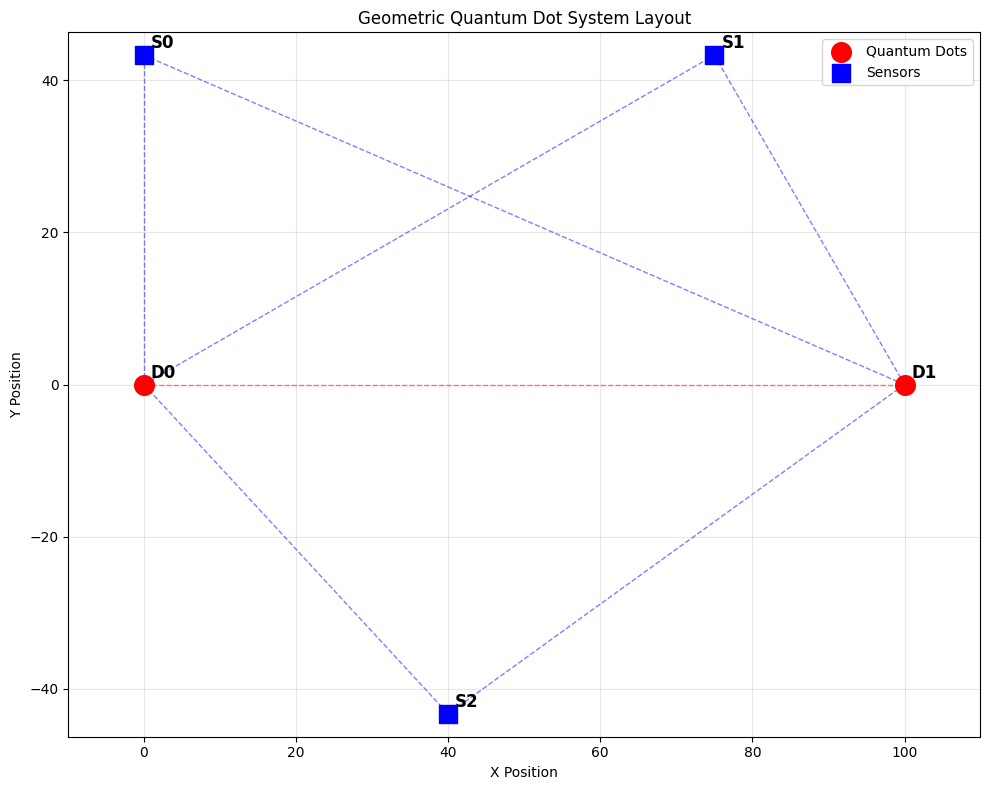


Complex system coupling information:
  Average dot-dot coupling: 7.43e-16 F
  Average dot-sensor coupling: 5.66e-16 F
  Max coupling strength: 1.144
  Min coupling strength: 1.016


3. Integrating with full ReadSpyn simulator...
Using geometric system: 2 dots, 3 sensors
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 5.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 5.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.516e+08 Hz
  Resonant period = 3.974e-09 s
  Capacitance noise model: OU_noise
  Energy noise model: OU_noise
Sensor resonant frequency: 0.25 GHz
Precomputing 1000 noise trajectory segments...
Noise trajectory segments precomputed successfully.
Running simulation for 3 charge states with 1000 realizations...
Processing sensor 0...
Sensor 0: Average separation = 0.000018
Processing sensor 1...
Sensor 1: Average separation = 0.000014
Processing sensor 2...
Sens

In [1]:
#!/usr/bin/env python3
"""
Geometric Quantum Dot System Example

This script demonstrates how to define quantum dot systems using geometric positions
of dots and sensors, allowing users to specify physical layouts and automatically
compute capacitance matrices based on geometric considerations.

Key Features:
1. Geometric positioning: Define dots and sensors by their 2D or 3D positions
2. Automatic capacitance computation: Capacitance matrices are computed based on distances
3. Visual system layout: Plot the geometric arrangement of dots and sensors
4. Configurable parameters: Adjust coupling strength and distance decay parameters
5. Integration with existing simulator: Use the geometric system with the full ReadSpyn simulator

Implementation Details:
- Dot-dot capacitances follow C_ij = C0 for i=j, -α*C0*exp(-β*d_ij) for i≠j
- Dot-sensor capacitances follow C_ij = -α*C0*exp(-β*d_ij)
- Distances are computed using Euclidean norm
- The system integrates seamlessly with existing ReadSpyn components
"""

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any
import sys
import os

# Add the src directory to the path
sys.path.append("../src/")

try:
    from readout_simulator import (
        GeometricQuantumDotSystem,
        RLC_sensor, 
        JAXReadoutSimulator,
        OU_noise, 
        OverFNoise
    )
    print("✓ Successfully imported ReadSpyn components")
except ImportError as e:
    print(f"✗ Failed to import ReadSpyn components: {e}")
    sys.exit(1)


print("ReadSpyn Geometric Quantum Dot System Example")
print("=" * 50)

# Set JAX random key for reproducibility
key = jax.random.PRNGKey(42)

# Example 1: Simple 2-dot, 1-sensor system
print("\n1. Creating a simple 2-dot, 1-sensor system...")


# Example 2: More complex 3-dot, 2-sensor system
print("\n\n2. Creating a more complex 3-dot, 2-sensor system...")

# Define positions for a triangular arrangement
dot_positions = np.array([
    [0.0, 0.0], [100., 0.],      # Dot 1     # Dot 3 (equilateral triangle)
])

sensor_positions = np.array([
    [0, 43.3],    # Sensor 1 (center of triangle)
    [75.0, 43.3],
    [40.0, -43.3]     # Sensor 2 (offset from center)
])

# Create geometric system with different parameters
geo_system = GeometricQuantumDotSystem(
    dot_positions=dot_positions,
    sensor_positions=sensor_positions,
    C0=1e-15,      # Base capacitance: 1 fF
    alpha=0.8,     # Stronger coupling
    beta=0.005     # Longer range coupling
)

print(f"Created complex geometric system: {geo_system}")

# Plot the complex system layout
print("\nPlotting complex system layout...")
geo_system.plot_system(show_capacitances=True, capacitance_threshold=0.005)

# Get coupling information for complex system
coupling_info_2 = geo_system.get_coupling_info()
print(f"\nComplex system coupling information:")
print(f"  Average dot-dot coupling: {coupling_info_2['avg_dot_dot_coupling']:.2e} F")
print(f"  Average dot-sensor coupling: {coupling_info_2['avg_dot_sensor_coupling']:.2e} F")
print(f"  Max coupling strength: {coupling_info_2['max_coupling']:.3f}")
print(f"  Min coupling strength: {coupling_info_2['min_coupling']:.3f}")

# Example 3: Integration with full simulator
print("\n\n3. Integrating with full ReadSpyn simulator...")

# Use the first geometric system for simulation
dot_system = geo_system.dot_system

print(f"Using geometric system: {dot_system.num_dots} dots, {dot_system.num_sensors} sensors")

# Configure sensor parameters
params_resonator = {
    'Lc': 800e-9,      # Inductance (H)
    'Cp': 0.5e-12,     # Parasitic capacitance (F)
    'RL': 40,          # Load resistance (Ω)
    'Rc': 100e6,       # Coupling resistance (Ω)
    'Z0': 50           # Characteristic impedance (Ω)
}

params_coulomb_peak = {
    'g0': 1/50,        # Maximum conductance (S)
    'eps0': 0.5,       # Operating point (relative to eps_width)
    'eps_width': 1.0   # Energy width (eV)
}

# Create noise models
eps_noise = OU_noise(sigma=1e-1, gamma=1e2) # gamma = 1/tc , tc = 1e-5


c_noise = OU_noise(sigma=1e-99, gamma=1e4)

# Create sensor
sensor1 = RLC_sensor(params_resonator, params_coulomb_peak, c_noise, eps_noise)


print(f"Sensor resonant frequency: {sensor1.f0/1e9:.2f} GHz")

# Create simulator
simulator = JAXReadoutSimulator(dot_system, [sensor1]*3) #what happend here?

# Define charge states to simulate
charge_states = jnp.array([
    [1, 0],  # First dot occupied
    [0, 1],
    [2, 1]  # Second dot occupied,  # Third dot occupied
])
    

results_dict = {}
# Define simulation parameters
t_end = 1e-6  # 1 μs absolute end time
dt = 0.5e-9   # 0.5 ns time step
times = jnp.arange(0, t_end, dt)

n_realizations = 1000

snr = 5
params = {
        'eps0': 0.0,
        'snr': snr,
        't_end': t_end
    }



key, subkey = jax.random.split(key)
simulator.precompute_noise(subkey, times, n_realizations, eps_noise)


key, subkey = jax.random.split(key)
results = simulator.run_simulation(charge_states, times, params, subkey)


    

    # Extract data for plotting

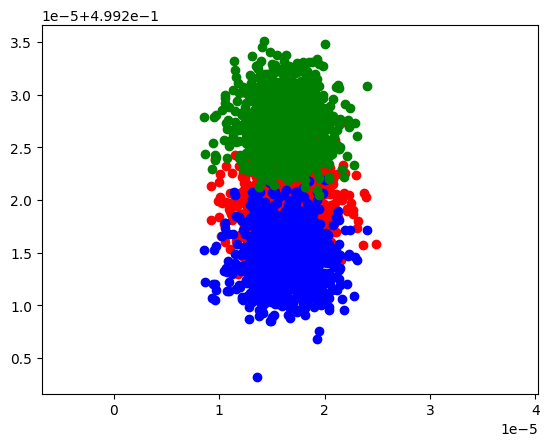

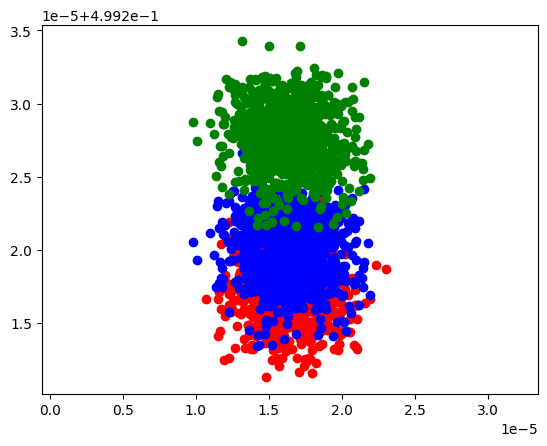

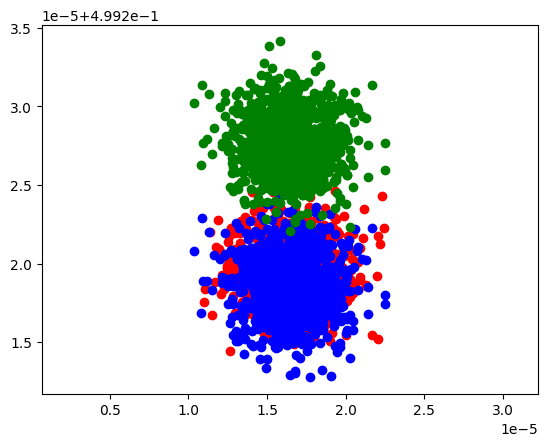

In [2]:
colors = ['red', 'blue', 'green', 'orange']


for sensor_indx in range(3):
    plt.figure()
    for state_indx in range(len(charge_states)):
        I = results['sensor_results'][sensor_indx]['I'][state_indx]
        Q = results['sensor_results'][sensor_indx]['Q'][state_indx]
        
        I_integrated = np.cumsum(I, axis=-1)/np.arange(1, len(I[0])+1)
        Q_integrated = np.cumsum(Q, axis=-1)/np.arange(1, len(Q[0])+1)

        plt.scatter(I_integrated[:,-1], Q_integrated[:,-1], label=f'state {state_indx}', color=colors[state_indx])
        plt.axis('equal')


(2000.0, 2100.0)

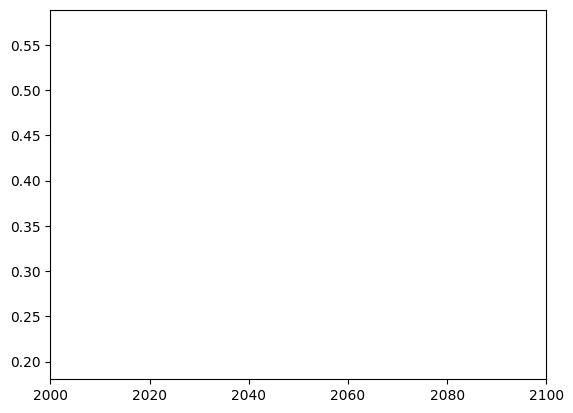

In [17]:
Q_st1 = results['sensor_results'][sensor_indx]['Q'][0]
Q_st2 = results['sensor_results'][sensor_indx]['Q'][2]
plt.plot(Q_st1[0])
plt.plot(Q_st2[0])
plt.xlim(2000,2100)


In [ ]:

I = sensor0['I'][0]
Q = sensor0['Q'][0]
    
I_integrated = np.cumsum(I, axis=-1)/np.arange(1, len(I[0])+1)
Q_integrated = np.cumsum(Q, axis=-1)/np.arange(1, len(Q[0])+1)









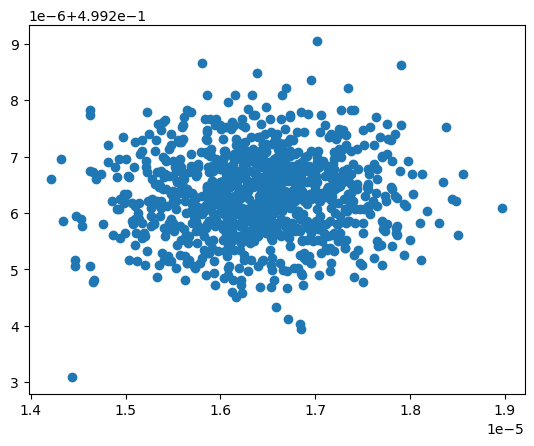

In [40]:
I = sensor1['I'][0]
Q = sensor1['Q'][0]
    
I_integrated = np.cumsum(I, axis=-1)/np.arange(1, len(I[0])+1)
Q_integrated = np.cumsum(Q, axis=-1)/np.arange(1, len(Q[0])+1)




plt.scatter(I_integrated[:,-1], Q_integrated[:,-1])

In [41]:
I2 = sensor2['I'][0]
Q2 = sensor2['Q'][0]

I_integrated = np.cumsum(I, axis=-1)/np.arange(1, len(I[0])+1)
Q_integrated = np.cumsum(Q, axis=-1)/np.arange(1, len(Q[0])+1)

I_integrated2 = np.cumsum(I2, axis=-1)/np.arange(1, len(I2[0])+1)
Q_integrated2 = np.cumsum(Q2, axis=-1)/np.arange(1, len(Q2[0])+1)

plt.scatter(I_integrated2[:,-1], Q_integrated2[:,-1], label='sensor2')
plt.scatter(I_integrated[:,-1], Q_integrated[:,-1], label='sensor1')
plt.legend()
plt.show()

TypeError: 'RLC_sensor' object is not subscriptable